# Imports

In [1]:
"""Dataset of Slither audited Solidity Smart Contracts."""

import json

import datasets
import pandas as pd

c:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Download do Dataset

Este conjunto de dados contém código-fonte e bytecode implantado para Solidity Smart Contracts que foram verificados no Etherscan.io, juntamente com uma classificação de suas vulnerabilidades de acordo com a estrutura de análise estática Slither.

Cada instância de dados contém os seguintes recursos: endereço, código fonte e bytecode. O rótulo vem em duas configurações, uma versão limpa em texto simples da saída fornecida pela ferramenta Slither ou uma versão com vários rótulos, que consiste em uma lista simples de números inteiros, cada um representando uma classe de vulnerabilidade específica.

Abaixo estão algumas variáveis e o código fonte disponibilizado pela autora do dataset para realizar o download do dataset de acordo com as especificações escolhidas.

In [3]:
_LABELS = {
    'all': [
        'uninitialized-state','constant-function-asm', 'locked-ether',
        'incorrect-shift', 'divide-before-multiply', 'unused-return',
        'write-after-write', 'reentrancy-no-eth', 'unchecked-lowlevel',
        'incorrect-equality', 'weak-prng', 'arbitrary-send',
        'uninitialized-local', 'reentrancy-eth', 'shadowing-abstract',
        'controlled-delegatecall', 'unchecked-transfer', 'erc20-interface',
        'controlled-array-length', 'tautology', 'shadowing-state',
        'tx-origin', 'unprotected-upgrade', 'suicidal',
        'boolean-cst', 'unchecked-send', 'msg-value-loop',
        'erc721-interface', 'constant-function-state', 'delegatecall-loop',
        'mapping-deletion', 'reused-constructor', 'uninitialized-storage',
        'public-mappings-nested', 'array-by-reference','backdoor',
        'rtlo', 'name-reused','safe'],
    'big': ['access-control', 'arithmetic', 'other', 'reentrancy', 'safe', 'unchecked-calls'],
    'small': ['access-control', 'arithmetic', 'other', 'reentrancy', 'safe', 'unchecked-calls', 'locked-ether', 'bad-randomness', 'double-spending']
}


_CITATION = """\
@misc{rossini2022slitherauditedcontracts,
    title = {Slither Audited Smart Contracts Dataset},
    author={Martina Rossini},
    year={2022}
}
"""


_DESCRIPTION = """\
This dataset contains source code and deployed bytecode for Solidity Smart Contracts \
that have been verified on Etherscan.io, along with a classification of their vulnerabilities \
according to the Slither static analysis framework.
"""

_HOMEPAGE = "https://github.com/mwritescode/slither-audited-smart-contracts"

_LICENSE = "MIT"


_URLS = {
    "raw": [f"data/raw/contracts{i}.parquet" for i in range(9)],
    "label_mappings": "data/label_mappings.json",
    "big-splits": "data/big-splits.csv",
    "small-splits": "data/small-splits.csv"
}

Código para baixar e salvar o dataset

In [5]:
class SlitherAuditedSmartContracts(datasets.GeneratorBasedBuilder):
    """Slither Audited Smart Contracts dataset, including source code and deployed bytecode"""

    VERSION = datasets.Version("1.1.0")

    # You will be able to load one or the other configurations in the following list with
    # data = datasets.load_dataset('slither-audited-smart-contracts', 'all-plain-text')
    BUILDER_CONFIGS = [
        datasets.BuilderConfig(name="all-plain-text", version=VERSION, description="Complete dataset with plain-text slither results"),
        datasets.BuilderConfig(name="all-multilabel", version=VERSION, description="Complete dataset with slither results as sequence of labels"),
        datasets.BuilderConfig(name="big-plain-text", version=VERSION, description="Dataset containing only labels having numerous examples with plain-text slither results"),
        datasets.BuilderConfig(name="big-multilabel", version=VERSION, description="Dataset containing only labels having numerous examples with slither results as a sequence of labels"),
        datasets.BuilderConfig(name="small-plain-text", version=VERSION, description="Dataset containing only labels having few examples with plain-text slither results"),
        datasets.BuilderConfig(name="small-multilabel", version=VERSION, description="Dataset containing only labels having few examples with slither results as a sequence of labels")
    ]

    def _info(self):
        if "plain-text" in self.config.name: 
            features = datasets.Features(
                {
                    "address": datasets.Value("string"),
                    "source_code": datasets.Value("string"),
                    "bytecode": datasets.Value("string"),
                    "slither": datasets.Value("string"),
                }
            )
        else: 
            features = datasets.Features(
                {
                    "address": datasets.Value("string"),
                    "source_code": datasets.Value("string"),
                    "bytecode": datasets.Value("string"),
                    "slither": datasets.Sequence(
                        datasets.features.ClassLabel(
                            names=_LABELS[self.config.name.split('-')[0]]
                        )
                    )
                    
                }
            )
        return datasets.DatasetInfo(
            description=_DESCRIPTION,
            features=features, 
            homepage=_HOMEPAGE,
            license=_LICENSE,
            citation=_CITATION,
        )

    def _split_generators(self, dl_manager):
        data_dir = dl_manager.download_and_extract(_URLS)

        generators = [
            datasets.SplitGenerator(
                name=datasets.Split.TRAIN,
                gen_kwargs={
                    "filepath": data_dir,
                    "split": "train"
                },
            )]
        if self.config.name.split('-')[0] != 'all':
            generators += [
                datasets.SplitGenerator(
                name=datasets.Split.TEST,
                gen_kwargs={
                    "filepath": data_dir,
                    "split": "test"
                },
            ),
            datasets.SplitGenerator(
                name=datasets.Split.VALIDATION,
                gen_kwargs={
                    "filepath": data_dir,
                    "split": "val"
                },
            )]
        return generators

    def __elaborate_results(self, slither_res, mappings):
        if not slither_res["results"]:
            contract_class = ["safe"]
        else:
            contract_class = [elem["check"] for elem in slither_res["results"]["detectors"]]
            if self.config.name.split('-')[0] != 'all':
                with open(mappings, 'r') as mappings_file:
                    class_mappings = json.load(mappings_file)
                contract_class = list(set([class_mappings[cls] for cls in contract_class]) - {'ignore'})
                if len(contract_class) == 0:
                    contract_class = ['safe']
        return contract_class


    def _generate_examples(self, filepath, split):
        prefix = self.config.name.split('-')[0]
        split_file = filepath[f"{prefix}-splits"] if prefix != 'all' else None

        for chunk in filepath['raw']:
            data = pd.read_parquet(chunk)
            if split_file:
                split_addrs = pd.read_csv(split_file).query('split == @split')['contracts']
                data = data[data['contracts'].isin(split_addrs)]

            for idx, row in data.iterrows():
                if 'plain-text' in self.config.name:
                    yield idx, {
                        "address": '0x' + row['contracts'],
                        "source_code": row['source_code'],
                        "bytecode": row['bytecode'],
                        "slither": row['results'],
                    }
                else:
                    slither = json.loads(row['results'])
                    contract_classes = self.__elaborate_results(slither, filepath['label_mappings'])
                    yield idx, {
                        "address": '0x' + row['contracts'],
                        "source_code": row['source_code'],
                        "bytecode": row['bytecode'],
                        "slither": contract_classes,
                    }

O código abaixo carrega o conjunto de dados com configuração "all-multilable", ou seja, todo o conjunto de dados porém a coluna de saída que contém a vulnerabilidade está descrita como numeral. Os dados são salvos na variável "train_examples" e em seguida são convertidos em um dataframe.

In [6]:

data = datasets.load_dataset('mwritescode/slither-audited-smart-contracts', 'all-multilabel')

# Acesse os exemplos de treinamento
train_examples = data['train']


c:\Python\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for mwritescode/slither-audited-smart-contracts contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mwritescode/slither-audited-smart-contracts
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [7]:
df = pd.DataFrame(train_examples)
#retirando as colunas que não serão necessárias
df = df.drop(columns=['address', 'bytecode'], axis= 1)

# Exibe as primeiras linhas do DataFrame
df

,source_code,slither
0,pragma solidity 0.5.4;\n\ninterface IERC20 {\n...,[4]
1,pragma solidity 0.6.10;\npragma experimental A...,"[6, 4, 9, 7]"
2,pragma solidity 0.6.5;\npragma experimental AB...,[38]
3,pragma solidity 0.6.6;\n\nlibrary Address {\n\...,[38]
4,pragma solidity 0.6.8;\npragma experimental AB...,"[0, 4, 7, 9, 16, 5, 2]"
...,...,...
120603,/**\n *Submitted for verification at Etherscan...,[38]
120604,contract ERC20Basic {\n uint256 public totalS...,[38]
120605,contract Bodies2 {\n\nstring public constant b...,[38]
120606,contract LifeSet_005 {\n \n// part.I_fixe.....,[38]


Aqui o df está sendo salvo em um arquivo parquet. Este formato em específico foi escolhido tanto pela eficiência em leitura quanto pelo tamanho final do arquivo.

In [8]:
df.to_parquet('slither_audited_contracts.parquet', index=False)

Verificando se o arquivo foi salvo corretamente

In [9]:
df = pd.read_parquet('slither_audited_contracts3.parquet')
df

,source_code,slither
0,pragma solidity 0.5.4;\n\ninterface IERC20 {\n...,[4]
1,pragma solidity 0.6.10;\npragma experimental A...,"[6, 4, 9, 7]"
2,pragma solidity 0.6.5;\npragma experimental AB...,[38]
3,pragma solidity 0.6.6;\n\nlibrary Address {\n\...,[38]
4,pragma solidity 0.6.8;\npragma experimental AB...,"[0, 4, 7, 9, 16, 5, 2]"
...,...,...
120603,/**\n *Submitted for verification at Etherscan...,[38]
120604,contract ERC20Basic {\n uint256 public totalS...,[38]
120605,contract Bodies2 {\n\nstring public constant b...,[38]
120606,contract LifeSet_005 {\n \n// part.I_fixe.....,[38]


In [10]:
df2 = df.copy()

O dataset inteiro contém cerca de 120.000 contratos inteligentes com e sem vulnerabilidades. Devido à limitações computacionais, optou-se pela diminuição do tamanho do dataset para treinamento da LLM.

In [11]:
count_38 = df['slither'].apply(lambda x: 38 in x).sum()

print("Total de contratos:", len(df))

print("Contratos sem vulnerabilidades:", count_38)

print("Proporção em relação ao total: {:.2f}%".format((count_38 / len(df))*100))

Total de contratos: 120608
Contratos sem vulnerabilidades: 35130
Proporção em relação ao total: 29.13%


A função abaixo cria um novo dataframe, que analisa a quantidade de vezes que cada vulnerabilidade aparece no dataset como um todo.

In [12]:
def vulnerabilidades(df):
    all_words = ['uninitialized-state','constant-function-asm', 'locked-ether','incorrect-shift', 'divide-before-multiply', 'unused-return','write-after-write', 'reentrancy-no-eth', 'unchecked-lowlevel','incorrect-equality', 'weak-prng', 'arbitrary-send','uninitialized-local', 'reentrancy-eth', 'shadowing-abstract','controlled-delegatecall', 'unchecked-transfer', 'erc20-interface','controlled-array-length', 'tautology', 'shadowing-state','tx-origin', 'unprotected-upgrade', 'suicidal','boolean-cst', 'unchecked-send', 'msg-value-loop',"erc721-interface", 'constant-function-state', 'delegatecall-loop','mapping-deletion', 'reused-constructor', 'uninitialized-storage','public-mappings-nested', 'array-by-reference','backdoor','rtlo', 'name-reused','safe']

    num_to_vulnerability = {i: word for i, word in enumerate(all_words)}
    all_numbers = [num for sublist in df['slither'] for num in sublist]
    counts = np.unique(all_numbers, return_counts=True)

    result_df = pd.DataFrame({'Número': counts[0], 'Contagem': counts[1]})
    result_df = result_df.sort_values(by='Contagem', ascending=False)
    result_df['Nome da Vulnerabilidade'] = result_df['Número'].map(num_to_vulnerability)

    return result_df

Como é possível ver abaixo, com exceção dos contratos sem vulnerabilidades descritos como "safe", algumas das vulnerabilidades mais comund encontradas são: "unused-return", "reentrancy" e "divide-before-multiply"

In [13]:
result_df = vulnerabilidades(df)
result_df

,Número,Contagem,Nome da Vulnerabilidade
5,5,42573,unused-return
38,38,35130,safe
7,7,21319,reentrancy-no-eth
4,4,20044,divide-before-multiply
13,13,17779,reentrancy-eth
12,12,17694,uninitialized-local
9,9,14507,incorrect-equality
16,16,14503,unchecked-transfer
11,11,10477,arbitrary-send
2,2,7517,locked-ether


O gráfico abaixo ilustra a tabela acima

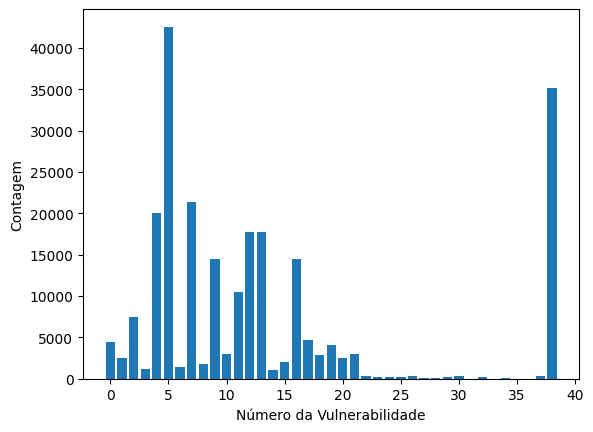

In [14]:
plt.bar(result_df['Número'], result_df['Contagem'])
plt.xlabel('Número da Vulnerabilidade')
plt.ylabel('Contagem')
plt.show()

Inicialmente, para fins de teste da LLM, criarei 5 datasets diferentes, cada um exemplificando as 5 maiores vulnerabilidades. Cada dataset conta com 2500 contratos vulneráveis e 2500 sem vulnerabilidades.

In [15]:
numeros = result_df['Número'].head(6).tolist()
print(numeros)

[5, 38, 7, 4, 13, 12]


In [16]:
df = df2.copy()

Criando 5 dataframes para cada vulnerabilidade e também com contratos seguros.

In [17]:
def criar_dataframes(numeros):
    dataframes = {}
    for numero in numeros:
        df_name = f'contratos_{numero}'  # Nome do DataFrame
        dataframes[df_name] = df[df['slither'].apply(lambda x: numero in x)]  # Criação do DataFrame
    
    return dataframes

dataframes = criar_dataframes(numeros)

São selecionadas 12500 linhas para o DataFrame com nome 'contratos_38' (seguros) e 2500 linhas para os outros DataFrames. Para facilitar o processo de treinamento, são escolhidas os menores contratos com base na quantidade de caracteres presentes.

In [24]:
for df_name, df in dataframes.items():
    # Calcula o tamanho das strings na coluna 'source_code' e adiciona como uma nova coluna
    df['source_code_length'] = df['source_code'].str.len()
    
    #seleciona os menores contratos
    if df_name == 'contratos_38':
        df_selected = df.nsmallest(12500, 'source_code_length', keep='all')
    else:
        df_selected = df.nsmallest(2500, 'source_code_length', keep='all')
    
    # Descarta a coluna 'source_code_length' se não for mais necessária
    df_selected.drop('source_code_length', axis=1, inplace=True)
    
    # Atualiza o DataFrame original com as alterações
    dataframes[df_name] = df_selected

Confirmando o tamanho e configurações dos datasets

In [19]:
for df_name in dataframes:
    print('nome:', df_name, '/ tam:', len(dataframes[df_name]))

nome: contratos_5 / tam: 2500
nome: contratos_38 / tam: 12500
nome: contratos_7 / tam: 2500
nome: contratos_4 / tam: 2500
nome: contratos_13 / tam: 2501
nome: contratos_12 / tam: 2500


Aqui, o dataset que contém os 12500 contratos seguros é dividido em 5 partes iguais

In [20]:
dataframes['contratos_38'] = dataframes['contratos_38'].sample(frac=1).reset_index(drop=True)
partes = np.array_split(dataframes['contratos_38'], 5)

c:\Python\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Convertendo as vulnerabilidades de números para palavras

In [21]:
vulnerabilities = [
    'uninitialized-state', 'constant-function-asm', 'locked-ether',
    'incorrect-shift', 'divide-before-multiply', 'unused-return',
    'write-after-write', 'reentrancy-no-eth', 'unchecked-lowlevel',
    'incorrect-equality', 'weak-prng', 'arbitrary-send',
    'uninitialized-local', 'reentrancy-eth', 'shadowing-abstract',
    'controlled-delegatecall', 'unchecked-transfer', 'erc20-interface',
    'controlled-array-length', 'tautology', 'shadowing-state',
    'tx-origin', 'unprotected-upgrade', 'suicidal',
    'boolean-cst', 'unchecked-send', 'msg-value-loop',
    'erc721-interface', 'constant-function-state', 'delegatecall-loop',
    'mapping-deletion', 'reused-constructor', 'uninitialized-storage',
    'public-mappings-nested', 'array-by-reference', 'backdoor',
    'rtlo', 'name-reused', 'safe'
]

# Criando o dicionário de mapeamento
def map_vulnerabilities(array):
    return [vulnerabilities[i] for i in array]

Concatenando os datasets vulneráveis com as partes do dataset seguro

In [25]:
for df_name, df in dataframes.items():
    c = 0
    if df_name != 'contratos_38':
       x = pd.concat([df, partes[c]], ignore_index=True)
       dataframes[df_name] = x
       dataframes[df_name].sample(frac=1).reset_index(drop=True)
       dataframes[df_name]['slither'] = dataframes[df_name]['slither'].apply(map_vulnerabilities)
       c+=1

Confirmando o número de contratos seguros e não seguros em cada df

In [26]:
for df_name, df in dataframes.items():
    seguro_count = (dataframes[df_name]['slither'].apply(lambda x: 'safe' in x)).sum()
    vulneraveis_count = len(df) - seguro_count
    print(f"Df {df_name} - Seguros: {seguro_count}, Vulneraveis: {vulneraveis_count}")

Df contratos_5 - Seguros: 2500, Vulneraveis: 2500
Df contratos_38 - Seguros: 0, Vulneraveis: 12500
Df contratos_7 - Seguros: 2500, Vulneraveis: 2500
Df contratos_4 - Seguros: 2500, Vulneraveis: 2500
Df contratos_13 - Seguros: 2500, Vulneraveis: 2501
Df contratos_12 - Seguros: 2500, Vulneraveis: 2500


Convertendo e salvando em arquivos .parquet

In [23]:
for df_name, df in dataframes.items():
    # Construa o nome do arquivo .parquet
    nome_arquivo = df_name + ".parquet"
    # Converta e salve o DataFrame como um arquivo .parquet
    df.to_parquet(nome_arquivo)

O próximo passo é realizar o treino e ajuste no modelo de LLM. Essas duas etapas podem necessitar de mais ajustes no dataset que serão devidamente documentadas e acrescentadas ao repositório.